# MRI Coding Challenge

## Questions to Stew On

- How much variance is there between the two sessions this subject underwent? Is there any way to make the random forest do anything but angrily say "no"?
- What is out-of-bag error?
    - bagging makes use of multiple overfitting trees to get better results
    - Maybe the error when the model is used on samples that were not part of the training?
    - Get this with RandomForestClassifier.oob_score_, which is simply an attribute of any RandomForestClassifier object.
- What is a class conditional posterior estimated random forest?
- Do I need to be using the affine transformation to manipulate this data in some way?

### TODOS

- TODO: Figure out what "Distribution of class conditional posteriors estimated random forest" means

### STRETCH GOALS

- Make widgets that move through the data interactively
- Turn a slice into a gif moving through the time sequence
- Find a way to make everything 3D

## An Aside

- I still have a ton I need to learn. I started teaching myself Python 3 years ago, but I imported Pandas for the first time 4 months ago, made my first real matplotlib graph a month ago, and this project will represent the first machine learning algorithm I've put into practice and the first time I've worked with MRI data.
- The above being said, [I](http://www.codecademy.com/) [have](https://automatetheboringstuff.com) [already](https://www.amazon.com/Introducing-Python-Modern-Computing-Packages/dp/1449359361/ref=sr_1_4?ie=UTF8&qid=1534734843&sr=8-4&keywords=introduction+to+python) [learned](https://www.datacamp.com/) [a](https://jakevdp.github.io/PythonDataScienceHandbook/) [great](https://www.amazon.com/Visual-Display-Quantitative-Information/dp/1930824130) [deal](https://www.amazon.com/Algorithms-Live-Computer-Science-Decisions/dp/1250118360/ref=sr_1_1?s=books&ie=UTF8&qid=1534918202&sr=1-1&keywords=algorithms+to+live+by), and [have](https://www.amazon.com/All-Statistics-Statistical-Inference-Springer/dp/0387402721/ref=sr_1_1?s=books&ie=UTF8&qid=1534735017&sr=1-1&keywords=all+of+statistics) [absolutely](https://www.amazon.com/Data-Science-Scratch-Principles-Python/dp/149190142X) [no](https://www.amazon.com/Think-Stats-Allen-B-Downey/dp/1449307116) [plans](https://www.amazon.com/Think-Bayes-Bayesian-Statistics-Python/dp/1449370780/ref=pd_lpo_sbs_14_img_2?_encoding=UTF8&psc=1&refRID=7XDCNW0MK8BQ9J8WEBJ2) [of](https://www.amazon.com/Advice-Young-Investigator-Bradford-Book/dp/0262681501/ref=sr_1_1?s=books&ie=UTF8&qid=1534735238&sr=1-1&keywords=advice+for+a+young+investigator) [stopping](https://www.amazon.com/Mathematics-Rebooted-Fresh-Approach-Understanding-ebook/dp/B07661R8N4) [any](https://www.amazon.com/Envisioning-Information-Edward-R-Tufte/dp/0961392118) [time](https://www.amazon.com/Introduction-Statistical-Learning-Applications-Statistics/dp/1461471370) [soon.](https://web.stanford.edu/~hastie/ElemStatLearn/)
- My hope is that I could contribute a ton in the long term.
- A fun sidenote to this aside: I read [this](http://worrydream.com/#!/ScientificCommunicationAsSequentialArt) paper while taking a break from working on this, and realized that the Vogelstein lab would love it! It's all about ways to make scientific communication more dynamic by embedding interactive visualizations inside the communication medium itself. The content happens to be small-world networks, which is right up your alley.

## Get the data

**Goals:**

- Load up both datasets from nifti files
- Load up all necessary libraries.

In [3]:
import pandas as pd  # in case I need it
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
np.set_printoptions(precision=2, suppress=True)  # For clarity
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # For clarity
import nilearn

In [4]:
mri1 = nib.load('sub-0025865_ses-1_dwi_aligned.nii')
mri2 = nib.load('sub-0025865_ses-2_dwi_aligned.nii')

In [117]:
mri1_data = mri1.get_data()[:, :, :, 1:]  # Turn into numpy data. This appears to be only an axial section.
mri2_data = mri2.get_data()[:, :, :, 1:]

mri1_hc = mri1.get_data()[:, :, :, 0]  # Separate out high contrast image
mri2_hc = mri2.get_data()[:, :, :, 0]

## First impressions of the data

**Goals:**

- Get a sense for what this data looks like.

In [130]:
mri1_data.shape

(182, 218, 182, 30)

182x218

In [131]:
mri1.shape == mri2.shape

True

In [132]:
mri1_data.dtype

dtype('<i2')

In [112]:
# I looked through the information here and didn't find anything useful, so I'm going to avoid calling it
# to not clutter the notebook
hdr = mri1.header

In [134]:
hdr.get_xyzt_units()
# Time is in seconds, size units are in millimeters.
# So I think this means each of the 30 time images comprise a second, and each scan contains 30 seconds of data,
# and each slice is one more millimeter vertically. This shall be the working hypothesis given no new information.

('mm', 'sec')

In [135]:
mri1.affine  # This relates voxel coordinates to real-world coordinates with a linear transformation.

array([[ -1.,   0.,   0.,  90.],
       [  0.,  -1.,   0.,  91.],
       [  0.,   0.,   1., -72.],
       [  0.,   0.,   0.,   1.]])

**Things I've figured out**:

- An affine array is a linear transformation that lets you move between real-world and voxel coordinates.
- This affine transformation is easy - it simply mirrors the x- and y-axis, and translates by the vector (90, 91, -72). If I wanted, I could use np.linalg.dot to perform the affine transformation.
- Units are in millimeters and seconds. I think this means each voxel is 1mm big.
- Both sessions contain very similar data.

# Problem

## 1. Scale the Data

**Task:**
- Figure out what the distribution of array values looks like.

In [154]:
# Get quick stats info on session 1
pd.Series(mri1_data.ravel()).describe()

count   216630960.00
mean           49.34
std            63.83
min           -30.00
25%             8.00
50%            15.00
75%            85.00
max           600.00
dtype: float64

In [155]:
# Get quick stats info on session 2
pd.Series(mri2_data.ravel()).describe()

count   216630960.00
mean           49.57
std            64.39
min           -36.00
25%             8.00
50%            15.00
75%            84.00
max           590.00
dtype: float64

**Results:**

- Mean of [49, 49] across the whole dataset.
- Min of [-30, -36].
- Max at [600, 590] but with a 75% of [85, 84], so there are some outliers.
- plt.imshow uses the highest value as the thing that defines 'white', so these outliers might lead to some brightness problems in the resulting image.
- mri1_data and mri2_data are extremely similar

**Next Step:**

- Get some histograms to look at what this looks like across z- slices.
- Since the two sets of data are so similar, I'm going to primarily use mri1_data to analyze (I could also average the two datasets if I wanted as well)
- Probably going to want to scale somewhere around vmin=10, vmax=100.

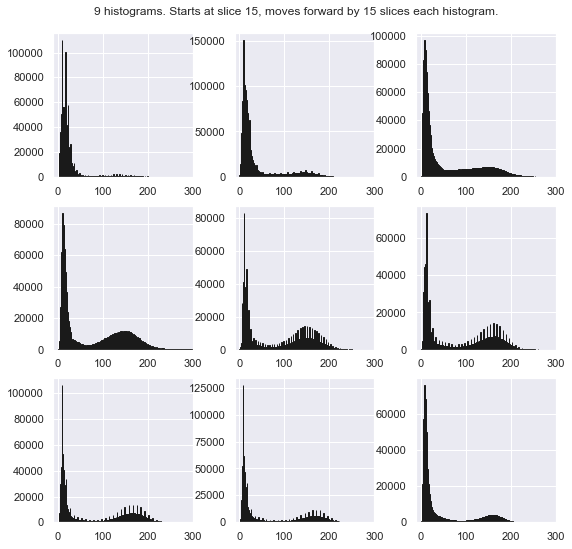

In [149]:
# TODO: scale data
# REMEMBER: first time-point (of the 31 time points) is a high-contrast point prior to testing

fig, ax = plt.subplots(3, 3, figsize=(9,9))

# Loop through every 15 axial slices of the first mri data, starting at slice 15, giving the histogram of
# individual value intensity for each slice.
for i, axi in enumerate(ax.flat):
    axi.hist(mri1_data[:, :, (15*i + 15), :].ravel(), bins=256,
             fc='k', ec='k');
    axi.set_xlim(-10, 300)  # To get all histograms in sync labels-wise

# Title the graph
fig.subplots_adjust(wspace=.3)
plt.suptitle('9 histograms. Starts at slice 15, moves forward by 15 slices each histogram.', y=0.92);

**Results:**


- Most spikes are in the range of [0, 200]
- Any outliers are going to skew the contrast, because the value determining a white pixel is based on the maximum value in a numpy array.
- The spikes around 0 are probably the black space around the edges of slices, which means the actual information is in the range of about [60, 250]

***

**Scaling:**
- Set vmin=60, vmax=200 (based on the histograms) for overall data.

### Plot the Data

- Now that scaling is determined, plot time=5 and z slice=15.

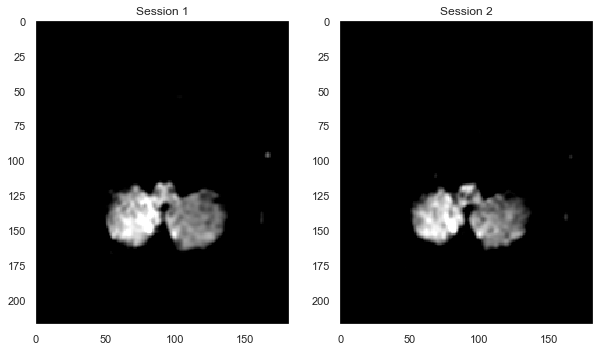

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 15))
z, t = 15, 5  # time begins with the high-contrast image, so I don't have to worry about 0-indexing.

# Show the data. Rotate 90 degrees because I like that view better.
ax1.imshow(np.rot90(mri1_data[:, :, z, t], k=3), cmap='gray', vmin=60, vmax=200)  # z=15 is where full image begins, z=150 is where full image ends
ax2.imshow(np.rot90(mri2_data[:, :, z, t], k=3), cmap='gray', vmin=60, vmax=200)

# grids are annoying
ax1.grid()
ax2.grid()

# Add title
ax1.set_title('Session 1');
ax2.set_title('Session 2');

- Out of curiosity, I'm also going to plot slice images for session 1.

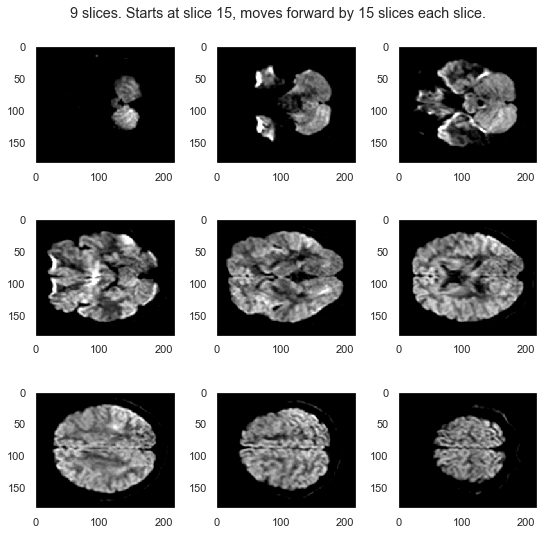

In [211]:
fig, ax = plt.subplots(3, 3, figsize=(9,9))

# Loop through every 15 axial slices of the first mri data, starting at slice 15, giving pictures
for i, axi in enumerate(ax.flat):
    axi.imshow(mri1_data[:, :, (15*i + 15), 0], vmin=60, vmax=250, cmap='gray')
    axi.grid()

# Title the graph
fig.subplots_adjust(wspace=.3)
plt.suptitle('9 slices. Starts at slice 15, moves forward by 15 slices each slice.', y=0.92);

- This background scaling looks gorgeous, really happy with it

## 2. Crop out a brain area, plot that region for each session

**The cerebellum is fun, and easy to see.**

- To do this, I'm going to figure out the coordinates defining a part of the left cerebellum, and then cut out a box around it.
- The box should include no non-brain information, so that later averaging won't include uninformative data
- I'm also going to use data averaged across time points.

In [108]:
# Make a box around the cerebellum, averaged across all time points
cerebellum1 = mri1_data[95:125, 135:165, 15:60, :].mean(axis=3)
cerebellum2 = mri2_data[95:125, 135:165, 15:60, :].mean(axis=3)

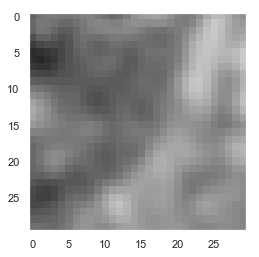

In [108]:
# Show slice 15 of that box
plt.imshow(cerebellum1[:, :, 15], cmap='gray', vmin=60, vmax=250)
plt.grid()

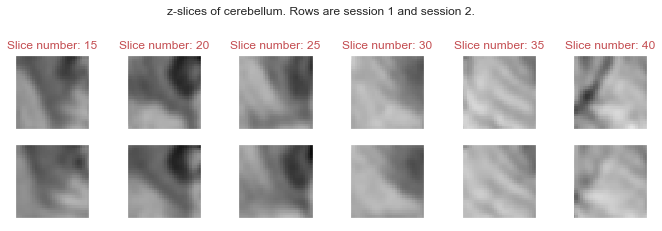

In [111]:
# TODO: figure out how to label the rows

fig, (ax1, ax2) = plt.subplots(2, 6, figsize=(12, 3))

# Plot slices for each session.
z, n = 15, 0  # z-slice and axis we're currently on

# Loop through and plot images
for i in range(6):  # Not happy with the inelegance of this implementation, but maybe that's just matplotlib
    ax1[n].imshow(np.rot90(cerebellum1[:, :, z], k=3), cmap='gray', vmin=60, vmax=250)
    ax2[n].imshow(np.rot90(cerebellum2[:, :, z], k=3), cmap='gray', vmin=60, vmax=250)
    
    ax1[n].set_xticks([])
    ax2[n].set_xticks([])
    ax1[n].set_yticks([])
    ax2[n].set_yticks([])
    
    ax1[n].set_title('Slice number: {}'.format(z), color='r')  # Dynamically set title for each slice
    
    n += 1
    z += 5

# Add title and adjust.
fig.subplots_adjust(wspace=0)
plt.suptitle('z-slices of cerebellum. Rows are session 1 and session 2.', y=1.1);

- This doesn't really look like much since it's such a zoomed-in part of the cerebellum, but at least it doesn't include background data

## 3. Choose a threshold/intensity value

**Choosing threshold value at slice 15: **

- Figure out what the distribution of pixel values looks like across all time periods for slice 15 specifically.
- Get the histogram and some summary statistics to look at the distribution of pixel values.
- But first, some fun with source code!

In [231]:
from nilearn._utils.extmath import fast_abs_percentile

In [235]:
# Get what nilearn thinks the auto threshold value should be
int(fast_abs_percentile(mri1_data) - 1e-5)

122

- I went into the nilearn source code and found the function that they use to figure out automated threshold values
- Then, I imported that function
- Then, I used it on this data, and a good threshold value appears to be 122. Cool.
- I am worried, however, that this function is using background information to generate this threshold.
- I'm not going to use this, and instead will do some work to get my own threshold.
- But now I know what a good order of magnitude looks like

In [119]:
# Get quick statistics information for slice 15 of my cerebellum box
sl15 = cerebellum1[:, :, 15]  # Non-high contrast time points
sl15_2 = cerebellum2[:, :, 15]

# Lets get a high-contrast cerebellum box as well
sl15_hc = mri1_hc[95:125, 135:165, 15]  # Never made a cerebellum box for the high-contrast, so doing it here
sl15_2_hc = mri2_hc[95:125, 135:165, 15]

In [123]:
rv = sl15.ravel()  # One dimensional data greater than 60
rv2 = sl15_2.ravel()
pd.Series(rv).describe()

count   900.00
mean    300.13
std      60.56
min     187.00
25%     252.00
50%     284.00
75%     347.00
max     488.00
dtype: float64

- Averaged data 50th percentile is 284

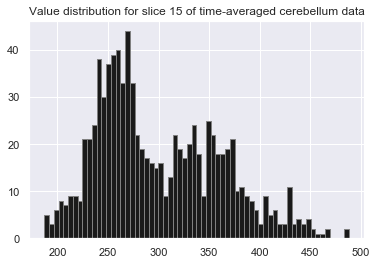

In [127]:
# Look at value distribution.
plt.hist(rv, bins=64, fc='k', ec='gray');
plt.title('Value distribution for slice 15 of time-averaged cerebellum data');

- There's a few outliers up in the 500 range, most values are in the 250 range
- Smaller values are more black in a plt.imshow image, larger values are more white

**Number of pixels above 284 at slice 15 for each session:**

In [128]:
a = len(rv[rv > 284])  # For session 1
a

449

In [131]:
b = len(rv2[rv2 > 284])
b

498

**Threshold:**

In [133]:
# Define a threshold value based on the histogram and descriptive statistics
thresh = 284

- Let's see what this looks like. Need a good way to plot this threshold...

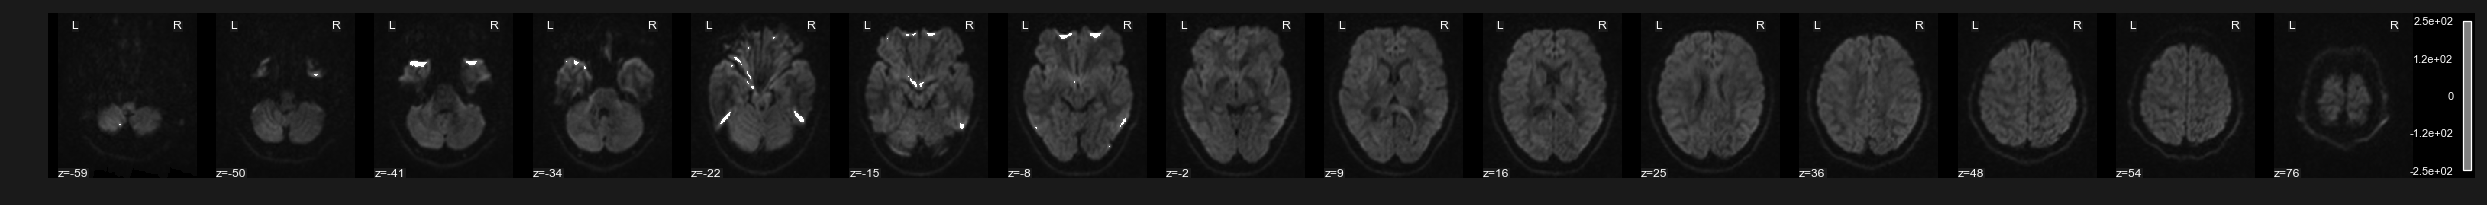

In [134]:
from nilearn import image, plotting  # Now we're talkin'

# Side-note: wow, the documentation for nilearn is great!
indexed = image.index_img(mri1, 1)
plotting.plot_stat_map(indexed, bg_img=indexed, threshold=thresh, display_mode="z", cut_coords=15,
                           colorbar=True, vmax=250);  # Side note, this is where I dove in and found that auto-threshold function from the source code

- I couldn't figure out how to get this function to plot the cerebellum box specifically, so this is just the whole brain
- Let's see what it looks like with a higher threshold
- Lots of activity in in the orbitofrontal cortex, parahippocampal gyrus, and some other places
- [This analysis is reminding me of a fun article I read a few years ago](https://blogs.scientificamerican.com/scicurious-brain/ignobel-prize-in-neuroscience-the-dead-salmon-study/)

## 4. Using threshold, perform simple first-order analysis

- Note: I didn't know what first-order analysis means, and because I wanted to limit the amount of questions I ask over email (and for the fun of the challenge), I decided not to ask you guys.
- After some googling, I decided that "simple first-order analysis" isn't a special term for a method specific to neuroimaging. I could be wrong, in which case the following analysis will be in an embarassingly incorrect direction.
- After some further etymological investigation, my working hypothesis is that first-order analysis means "analyze the data in whatever way is most interesting, but do it without using fancy methods involving derivatives". Hopefully that's not laughably wrong.
- I'm doing this for my cerebellum box specifically.

**Goal:**

- Average spatial data in my cerebellum box
- Plot that averaged spatial data over time for both session 1 and session 2

In [59]:
# Organize data for plotting
avg_data = cerebellum1[50, 50, 15, :]
time_dict = dict((i, x) for i, x in enumerate(rnd_pxl))  # Being fancy with dictionary comprehensions

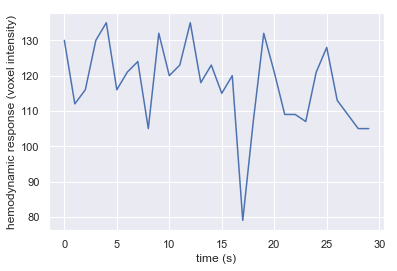

In [60]:
# Lineplot
# TODO: Add second session to this line plot

sns.lineplot(x=list(time_dict.keys()), y=list(time_dict.values()))  # Using seaborn for fun and practice
plt.xlabel('time (s)');
plt.ylabel('hemodynamic response (voxel intensity)');

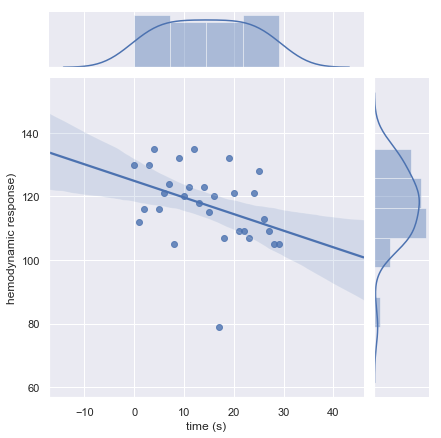

In [187]:
# Jointplot
sns.jointplot(x=list(time_dict.keys()), y=list(time_dict.values()), kind='reg',)  # Using seaborn for fun and practice
plt.xlabel('time (s)');
plt.ylabel('hemodynamic response)');

- Kind of hard to interpret.
- Need better way of analyzing this data holistically
- Need to explore another library for this

## 5. Train a random forest classifier to differentiate between sessions.

In [2]:
from sklearn.ensemble import RandomForestClassifier  # This should be the one

- I'm just going to use time point 0, the high-contrast point, for this.
- I'm not sure how I'd incorporate the higher-dimensional time data. Something to stew on.

In [19]:
# Reorganize data
# I want a 182 * 39676 array for each subject.
# Each of the 182 rows corresponds to a slice. 
# The 39676 values in each of those slices corresponds to a 1D version of the 182x218 image.

# Transpose into a better shape for this
mri1_hc = mri1_hc.transpose(2, 0, 1)
mri2_hc = mri2_hc.transpose(2, 0, 1)

# Reshape such that each of the 182 slices are 1-D
mri1_hc = mri1_hc.reshape(mri1_hc.shape[0], -1)
mri2_hc = mri2_hc.reshape(mri2_hc.shape[0], -1)

# Merge into a single new array, first array on top of second data
# (This is a kind of inelegant and potentially wrong way to do this, but oh well)
mri_hc = np.vstack((mri1_hc, mri2_hc))

In [20]:
# Make target array
mri1_target = np.full(mri1_hc.shape[0], 0)
mri2_target = np.full(mri2_hc.shape[0], 1)
mri_target = np.vstack((mri1_target, mri2_target)).ravel()

In [24]:
# Split into training data and testing data
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(mri_hc, mri_target,
                                               random_state=0)

In [35]:
# Make the classifier and predict
model = RandomForestClassifier(warm_start=True, oob_score=True, n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [36]:
# Explore results
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

          0       1.00      0.92      0.96        52
          1       0.91      1.00      0.95        39

avg / total       0.96      0.96      0.96        91



**Out of bag error:**

In [38]:
model.oob_score_

0.94505494505494503

In [39]:
1 - model.oob_score_

0.054945054945054972

- About 5.5% oob error rate
- This means that, for predictions of an element made from trees that don't contain that element, the tree guessed which session to put the element in wrong 5% of the time
- If I'm right on that, that seems pretty good. Could definitely be overfitting though

### Distribution of class conditional posteriors estimated random forest

In [191]:
model.n_classes_

2

# Ending Thoughts

- So, this analysis is actually a decent showcase of the skills I'd have to offer
- My stats background needs improvement (but it is improving quickly). That was painfully obvious to me throughout the analysis (it was super fun to do). I am aware that, with this lab specifically, that's a big issue. My hope is that my other strengths outweigh this.
- One thing I didn't really get to showcase here is that I feel fairly comfortable with the fundamentals of the Python programming language. [here](https://imgur.com/a/mauytSK) is a solution to a coding challenge I did the other day that gives some sense of that.
- I have plans to focus hard on ``sci-kit learn`` and visualization over the course of the next few months. I didn't have the chance to show my ability to play with data in ``Pandas``, since images don't lend themselves too well to that, but I consider myself not bad at it.
- Above all, I'm motivated and I love this stuff.